In [10]:
from google.colab import drive
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from keras.layers import Input, Dense
import tensorflow as tf
from keras.models import Model
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from tensorflow.keras.layers import Input, Dense, Reshape, Conv1D, MaxPooling1D, Flatten, BatchNormalization
from sklearn.model_selection import train_test_split


drive.mount('/content/drive')
path_to_directory="/content/drive/My Drive/Colab Notebooks/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Dataset 1: Annthyroid

In [11]:
data = pd.read_csv(path_to_directory + "Annthyroid_withoutdupl_07.csv")
data

,att1,att2,att3,att4,att5,att6,att7,att8,att9,att10,...,att14,att15,att16,att17,att18,att19,att20,att21,id,outlier
0,0.73,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.00060,0.0150,0.120,0.082,0.1460,1.0,'no'
1,0.24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00025,0.0300,0.143,0.133,0.1080,2.0,'no'
2,0.47,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00190,0.0240,0.102,0.131,0.0780,3.0,'no'
3,0.64,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00090,0.0170,0.077,0.090,0.0850,4.0,'no'
4,0.23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00025,0.0260,0.139,0.090,0.1530,5.0,'no'
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7124,0.59,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.00250,0.0208,0.079,0.099,0.0800,7196.0,'no'
7125,0.51,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.10600,0.0060,0.005,0.089,0.0055,7197.0,'yes'
7126,0.51,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.00076,0.0201,0.090,0.067,0.1340,7198.0,'no'
7127,0.35,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00280,0.0201,0.090,0.089,0.1010,7199.0,'no'


In [12]:

X_train, X_test, y_train, y_test = train_test_split(
    data.loc[data["outlier"] == "'no'",  data.columns[:21]],
    data.loc[data["outlier"] == "'no'", data.columns[-1]],
    random_state=104,
    test_size=0.2,
    shuffle=True
)

#ind = pd.concat([X_test.iloc[:, 0], data.loc[data["label"] == 1, column]])

X_test = pd.concat([X_test, data.loc[data["outlier"] == "'yes'", data.columns[:21]]], ignore_index=True)
y_test = pd.concat([y_test, data.loc[data["outlier"] == "'yes'", data.columns[-1]]], ignore_index=True)


In [13]:
scaler = StandardScaler()
scaled_data_train = scaler.fit_transform(X_train)
scaled_data_test = scaler.transform(X_test)

In [14]:

input_dim = X_train.shape[1]  # Input dimension
 # Dimension of the encoded representation

# Encoder
input_layer = Input(shape=(input_dim,))
autoencoder = tf.keras.models.Sequential([

    # deconstruct / encode
    tf.keras.layers.Dense(input_dim, activation='tanh', input_shape=(input_dim, )),
    tf.keras.layers.Dense(16, activation='tanh'),
    tf.keras.layers.Dense(8, activation='tanh'),
    tf.keras.layers.Dense(4, activation='tanh'),
    #tf.keras.layers.Dense(2, activation='tanh'),

    # reconstruction / decode
    #tf.keras.layers.Dense(4, activation='tanh'),
    tf.keras.layers.Dense(8, activation='tanh'),
    tf.keras.layers.Dense(16, activation='tanh'),
    tf.keras.layers.Dense(input_dim, activation='tanh')

])

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # The metric to monitor
    patience=5,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

# Compile the model
autoencoder.compile(optimizer='adam', loss='mse')

# Train the autoencoder
autoencoder.fit(X_train, X_train, epochs=30, batch_size=8, shuffle=True, validation_split=0.25, callbacks=[early_stopping])

Epoch 1/30
495/495 [==============================] - 9s 8ms/step - loss: 0.0226 - val_loss: 0.0132
Epoch 2/30
495/495 [==============================] - 3s 6ms/step - loss: 0.0132 - val_loss: 0.0118
Epoch 3/30
495/495 [==============================] - 3s 7ms/step - loss: 0.0123 - val_loss: 0.0115
Epoch 4/30
495/495 [==============================] - 2s 4ms/step - loss: 0.0122 - val_loss: 0.0114
Epoch 5/30
495/495 [==============================] - 2s 4ms/step - loss: 0.0120 - val_loss: 0.0112
Epoch 6/30
495/495 [==============================] - 2s 5ms/step - loss: 0.0120 - val_loss: 0.0112
Epoch 7/30
495/495 [==============================] - 2s 4ms/step - loss: 0.0120 - val_loss: 0.0112
Epoch 8/30
495/495 [==============================] - 1s 3ms/step - loss: 0.0119 - val_loss: 0.0112
Epoch 9/30
495/495 [==============================] - 1s 3ms/step - loss: 0.0119 - val_loss: 0.0111
Epoch 10/30
495/495 [==============================] - 2s 4ms/step - loss: 0.0119 - val_loss: 0.0111

58/58 [==============================] - 1s 4ms/step


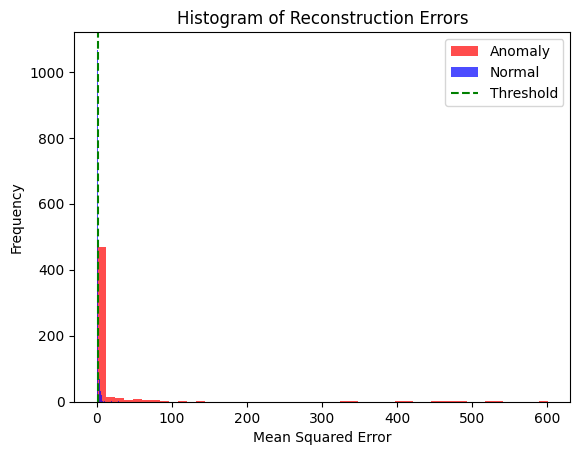

pr_auc:  0.6575475689504874
ROC AUC: 0.7592603635145226


In [16]:

reconstructed_data = autoencoder.predict(scaled_data_test)

le = LabelEncoder()
y_test = le.fit_transform(y_test)
# Calculate Mean Squared Error for each sample
mse_per_sample = np.mean(np.square(scaled_data_test - reconstructed_data), axis=1)


# Separate anomalies and normal samples based on labels
anomalies = mse_per_sample[y_test == 1]
normal_samples = mse_per_sample[y_test == 0]

threshold = np.percentile(mse_per_sample, 70)
# Plot histogram for anomalies
plt.hist(anomalies, bins=50, color='r', alpha=0.7, label='Anomaly')

# Plot histogram for normal samples
plt.hist(normal_samples, bins=50, color='b', alpha=0.7, label='Normal')
plt.axvline(x = threshold, color='green', linestyle='--', label='Threshold')
plt.title('Histogram of Reconstruction Errors')
plt.xlabel('Mean Squared Error')
plt.ylabel('Frequency')
plt.legend()
plt.show()

#print(mse_per_sample)


# Create binary arrays indicating whether each element is anomalous or not
anomalies = np.where(mse_per_sample >threshold, 1, 0)


fpr, tpr, thresholds = metrics.roc_curve(y_test, anomalies)
pr_auc = metrics.auc(fpr, tpr)
#print(thresholds)

print("pr_auc: ",pr_auc)
print("ROC AUC:",roc_auc_score(y_test, mse_per_sample))


# Dataset 2: Breast Cancer Wisconson

In [49]:
data = pd.read_csv(path_to_directory + "breast-cancer-wisconsin.csv")
#some data reading process
data = pd.DataFrame(np.vstack([data.columns, data]))

data.columns=  ["id", "Clump Thickness","Uniformity of Cell Size","Uniformity of Cell Shape","Marginal Adhesion",
                "Single Epithelial Cell Size","Bare Nuclei","Bland Chromatin","Normal Nucleoli",  "Mitoses", "Class"]
l  = [5,1,1,1,2,1,3,1,1,2]
for i in range(1,len(data.columns)):

    data.iloc[0,i] = l[i-1]
    data = data[data.iloc[:,i] != "?"]
data

,id,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...
694,776715,3,1,1,1,3,2,1,1,1,2
695,841769,2,1,1,1,2,1,1,1,1,2
696,888820,5,10,10,3,7,3,8,10,2,4
697,897471,4,8,6,4,3,4,10,6,1,4


In [50]:
# ensuring that only train data contains normal data
data = data.astype(np.float32)
le = LabelEncoder()
data["label"] = le.fit_transform(data["Class"])

data ["Class"] = data["label"]
data_normal = data[data["Class"] == 1]
X_train, X_test, y_train, y_test = train_test_split(data_normal.loc[:, data.columns],data_normal.loc[:, "Class"],
                                   random_state=104,
                                   test_size=0.25,
                                   shuffle=True)

#print(len(y_test),len(X_train), len(X_test) )
X_test = pd.concat([X_test, data.loc[data["Class"] == 0, data.columns]], ignore_index=True)
y_test = pd.concat([y_test, data.loc[data["Class"] == 0, "Class"]], ignore_index=True)
#print(len(y_test), len(X_train), len(X_test))

# normalizing the train and test data
sc = StandardScaler()
scaled_data_train = sc.fit_transform(X_train)
scaled_data_test = sc.fit_transform(X_test)


In [51]:
input_dim = X_train.shape[1]  # Input dimension
 # Dimension of the encoded representation

# Encoder
input_layer = Input(shape=(input_dim,))
autoencoder = tf.keras.models.Sequential([

    # deconstruct / encode
    tf.keras.layers.Dense(input_dim, activation='tanh', input_shape=(input_dim, )),
    #tf.keras.layers.Dense(8, activation='tanh'),
    tf.keras.layers.Dense(8, activation='tanh'),
    tf.keras.layers.Dense(4, activation='tanh'),


    # reconstruction / decode
    tf.keras.layers.Dense(2, activation='tanh'),
    tf.keras.layers.Dense(4, activation='tanh'),
    tf.keras.layers.Dense(8, activation='tanh'),
    #tf.keras.layers.Dense(16, activation='tanh'),
    tf.keras.layers.Dense(input_dim, activation='tanh')

])
# Compile the model
autoencoder.compile(optimizer='adam', loss='mse')
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # The metric to monitor
    patience=5,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)
# Train the autoencoder
autoencoder.fit(X_train, X_train, epochs=30, batch_size=8, shuffle=True, validation_split=0.25, callbacks=[early_stopping])

Epoch 1/30
17/17 [==============================] - 2s 25ms/step - loss: 92307709952.0000 - val_loss: 90316029952.0000
Epoch 2/30
17/17 [==============================] - 0s 8ms/step - loss: 92307668992.0000 - val_loss: 90316005376.0000
Epoch 3/30
17/17 [==============================] - 0s 7ms/step - loss: 92307652608.0000 - val_loss: 90315988992.0000
Epoch 4/30
17/17 [==============================] - 0s 6ms/step - loss: 92307628032.0000 - val_loss: 90315956224.0000
Epoch 5/30
17/17 [==============================] - 0s 7ms/step - loss: 92307611648.0000 - val_loss: 90315939840.0000
Epoch 6/30
17/17 [==============================] - 0s 6ms/step - loss: 92307587072.0000 - val_loss: 90315931648.0000
Epoch 7/30
17/17 [==============================] - 0s 7ms/step - loss: 92307578880.0000 - val_loss: 90315915264.0000
Epoch 8/30
17/17 [==============================] - 0s 7ms/step - loss: 92307578880.0000 - val_loss: 90315915264.0000
Epoch 9/30
17/17 [==============================] - 0s 

16/16 [==============================] - 0s 2ms/step
504
504 504


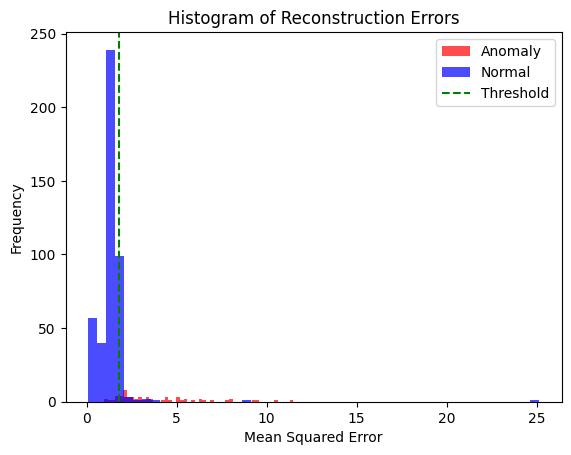

pr_auc:  0.9063063063063063
ROC AUC: 0.9356981981981982


In [52]:
# testing

#encode labels
le = LabelEncoder()
y_test = le.fit_transform(y_test)

# Use the trained autoencoder to reconstruct the test set
reconstructed_data = autoencoder.predict(scaled_data_test)
print(len(scaled_data_test))
# Calculate Mean Squared Error for each sample
mse_per_sample = np.mean(np.square(scaled_data_test - reconstructed_data), axis=1)
print(len(mse_per_sample), len(y_test))
# Separate anomalies and normal samples based on labels
anomalies = mse_per_sample[y_test == 1]
normal_samples = mse_per_sample[y_test == 0]
threshold = np.percentile(mse_per_sample,85) # Adjust this threshold as needed


# Plot histogram for anomalies
plt.hist(anomalies, bins=50, color='r', alpha=0.7, label='Anomaly')

# Plot histogram for normal samples
plt.hist(normal_samples, bins=50, color='b', alpha=0.7, label='Normal')
plt.axvline(x = threshold, color='green', linestyle='--', label='Threshold')
plt.title('Histogram of Reconstruction Errors')
plt.xlabel('Mean Squared Error')
plt.ylabel('Frequency')
plt.legend()
plt.show()

#print(mse_per_sample)



# Create binary arrays indicating whether each element is anomalous or not
anomalies = np.where(mse_per_sample > threshold, 1, 0)


fpr, tpr, thresholds = metrics.roc_curve(y_test, anomalies)
pr_auc = metrics.auc(fpr, tpr)
#print(thresholds)


print("pr_auc: ",pr_auc)
print("ROC AUC:",roc_auc_score(y_test, mse_per_sample))



# Dataset 3: Cardio

In [28]:
f=np.load("/content/drive/My Drive/Colab Notebooks/cardio.npz")
data = {1: "x", 2:"y" ,3:'z'}
for (i,j) in enumerate(f):
    data[i+1] = f[j]
x = data[1]
tx = data[2]
ty = data[3]
print(x.shape)
print(tx.shape)
print(ty.shape)

(1479, 21)
(352, 21)
(352,)


In [30]:
input_dim = tx.shape[1]  # Input dimension

# Encoder
input_layer = Input(shape=(input_dim,))
autoencoder = tf.keras.models.Sequential([

    # deconstruct / encode
    tf.keras.layers.Dense(input_dim, activation='tanh', input_shape=(input_dim, )),
    #tf.keras.layers.Dense(256, activation='relu'),
    #tf.keras.layers.Dense(128, activation='relu'),
    #tf.keras.layers.Dense(64, activation='relu'),
    #tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='tanh'),
    tf.keras.layers.Dense(8, activation='tanh'),
    #tf.keras.layers.Dense(4, activation='tanh'),

    # reconstruction / decode
    #tf.keras.layers.Dense(2, activation='tanh'),
    tf.keras.layers.Dense(4, activation='tanh'),
    tf.keras.layers.Dense(8, activation='tanh'),
    tf.keras.layers.Dense(16, activation='tanh'),
    #tf.keras.layers.Dense(32, activation='relu'),
    #tf.keras.layers.Dense(64, activation='relu'),
    #tf.keras.layers.Dense(128, activation='relu'),
    #tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(input_dim, activation='linear')

])


early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # The metric to monitor
    patience=5,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)
# Compile the model
autoencoder.compile(optimizer='adam', loss='mse')

# Train the autoencoder
autoencoder.fit(x, x, epochs=30, batch_size=8, shuffle=True, validation_split=0.25, callbacks=[early_stopping])


Epoch 1/30
148/148 [==============================] - 3s 5ms/step - loss: 0.6896 - val_loss: 0.5155
Epoch 2/30
148/148 [==============================] - 1s 4ms/step - loss: 0.4913 - val_loss: 0.3982
Epoch 3/30
148/148 [==============================] - 1s 9ms/step - loss: 0.4150 - val_loss: 0.3551
Epoch 4/30
148/148 [==============================] - 1s 5ms/step - loss: 0.3773 - val_loss: 0.3216
Epoch 5/30
148/148 [==============================] - 1s 4ms/step - loss: 0.3485 - val_loss: 0.3026
Epoch 6/30
148/148 [==============================] - 1s 4ms/step - loss: 0.3342 - val_loss: 0.2927
Epoch 7/30
148/148 [==============================] - 1s 4ms/step - loss: 0.3259 - val_loss: 0.2865
Epoch 8/30
148/148 [==============================] - 0s 3ms/step - loss: 0.3206 - val_loss: 0.2804
Epoch 9/30
148/148 [==============================] - 0s 3ms/step - loss: 0.3164 - val_loss: 0.2761
Epoch 10/30
148/148 [==============================] - 0s 3ms/step - loss: 0.3129 - val_loss: 0.2730

11/11 [==============================] - 0s 3ms/step


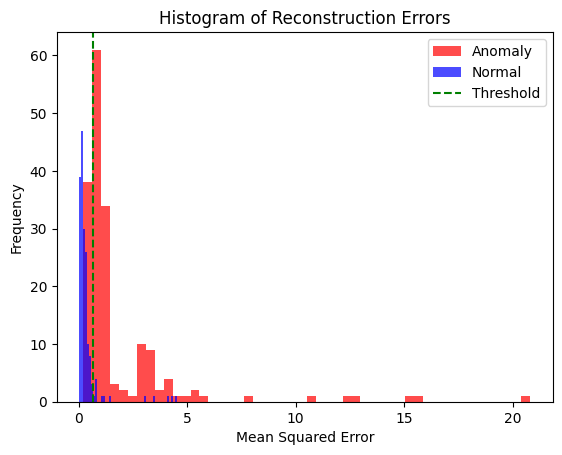

pr_auc:  0.8267045454545454
ROC AUC: 0.9250710227272727


In [37]:
# testing


# Use the trained autoencoder to reconstruct the test set
reconstructed_data = autoencoder.predict(tx)

# Calculate Mean Squared Error for each sample
mse_per_sample = np.mean(np.square(tx - reconstructed_data), axis=1)

# Separate anomalies and normal samples based on labels
anomalies = mse_per_sample[ty == 1]
normal_samples = mse_per_sample[ty == 0]
threshold = np.percentile(mse_per_sample,60) # Adjust this threshold as needed


# Plot histogram for anomalies
plt.hist(anomalies, bins=50, color='r', alpha=0.7, label='Anomaly')

# Plot histogram for normal samples
plt.hist(normal_samples, bins=50, color='b', alpha=0.7, label='Normal')
plt.axvline(x = threshold, color='green', linestyle='--', label='Threshold')
plt.title('Histogram of Reconstruction Errors')
plt.xlabel('Mean Squared Error')
plt.ylabel('Frequency')
plt.legend()
plt.show()

#print(mse_per_sample)



# Create binary arrays indicating whether each element is anomalous or not
anomalies = np.where(mse_per_sample > threshold, 1, 0)


fpr, tpr, thresholds = metrics.roc_curve(ty, anomalies)
pr_auc = metrics.auc(fpr, tpr)
#print(thresholds)


print("pr_auc: ",pr_auc)
print("ROC AUC:",roc_auc_score(ty, mse_per_sample))



# Dataset 4: Gas building float

In [54]:
f=np.load("/content/drive/My Drive/Colab Notebooks/Sadia/datasets/Glass_building_float.npz")
data = {1: "x", 2:"y" ,3:'z'}
for (i,j) in enumerate(f):
    data[i+1] = f[j]
x_train = data[1]
tx = data[2]
ty = data[3]

In [55]:
scaler = MinMaxScaler()
scaled_data_train = scaler.fit_transform(x_train)
scaled_data_test = scaler.transform(tx)

In [58]:
input_dim = x_train.shape[1]  # Input dimension

# Encoder
input_layer = Input(shape=(input_dim,))

autoencoder = tf.keras.models.Sequential([

    # deconstruct / encode
    tf.keras.layers.Dense(input_dim, activation='tanh', input_shape=(input_dim, )),
    #tf.keras.layers.Dense(16, activation='tanh'),
    tf.keras.layers.Dense(256, activation='tanh'),
    tf.keras.layers.Dense(128, activation='tanh'),
    tf.keras.layers.Dense(64, activation='tanh'),
    tf.keras.layers.Dense(32, activation='tanh'),
    tf.keras.layers.Dense(16, activation='tanh'),
    tf.keras.layers.Dense(8, activation='tanh'),

    # reconstruction / decode
    #tf.keras.layers.Dense(4, activation='tanh'),
    #tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(16, activation='tanh'),
    tf.keras.layers.Dense(32, activation='tanh'),
    tf.keras.layers.Dense(64, activation='tanh'),
    tf.keras.layers.Dense(128, activation='tanh'),
    tf.keras.layers.Dense(256, activation='tanh'),
    tf.keras.layers.Dense(input_dim, activation='linear')

])

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # The metric to monitor
    patience=5,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)
# Compile the model
autoencoder.compile(optimizer='adam', loss='mse')

# Train the autoencoder
autoencoder.fit(scaled_data_train, scaled_data_train, epochs=30, batch_size=8, shuffle=True, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/30
5/5 [==============================] - 3s 92ms/step - loss: 0.1515 - val_loss: 0.0635
Epoch 2/30
5/5 [==============================] - 0s 21ms/step - loss: 0.0798 - val_loss: 0.0450
Epoch 3/30
5/5 [==============================] - 0s 20ms/step - loss: 0.0750 - val_loss: 0.0317
Epoch 4/30
5/5 [==============================] - 0s 20ms/step - loss: 0.0544 - val_loss: 0.0249
Epoch 5/30
5/5 [==============================] - 0s 16ms/step - loss: 0.0419 - val_loss: 0.0173
Epoch 6/30
5/5 [==============================] - 0s 16ms/step - loss: 0.0302 - val_loss: 0.0183
Epoch 7/30
5/5 [==============================] - 0s 19ms/step - loss: 0.0276 - val_loss: 0.0105
Epoch 8/30
5/5 [==============================] - 0s 17ms/step - loss: 0.0212 - val_loss: 0.0112
Epoch 9/30
5/5 [==============================] - 0s 19ms/step - loss: 0.0211 - val_loss: 0.0121
Epoch 10/30
5/5 [==============================] - 0s 15ms/step - loss: 0.0185 - val_loss: 0.0070
Epoch 11/30
5/5 [============

2/2 [==============================] - 0s 7ms/step


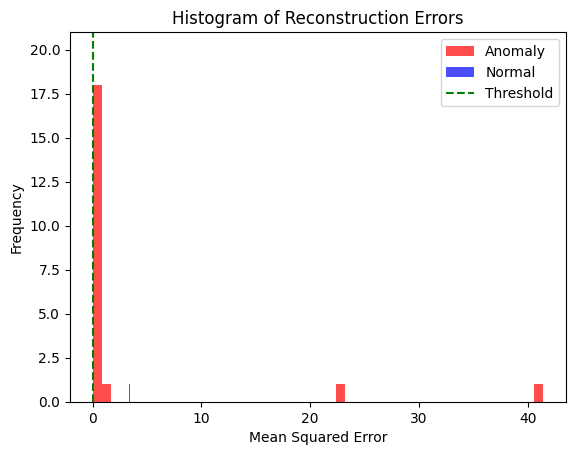

pr_auc:  0.6666666666666667
ROC AUC: 0.7619047619047619


In [60]:
# testing


# Use the trained autoencoder to reconstruct the test set
reconstructed_data = autoencoder.predict(scaled_data_test)

# Calculate Mean Squared Error for each sample
mse_per_sample = np.mean(np.square(scaled_data_test - reconstructed_data), axis=1)

# Separate anomalies and normal samples based on labels
anomalies = mse_per_sample[ty == 1]
normal_samples = mse_per_sample[ty == 0]
threshold = np.percentile(mse_per_sample,45) # Adjust this threshold as needed


# Plot histogram for anomalies
plt.hist(anomalies, bins=50, color='r', alpha=0.7, label='Anomaly')

# Plot histogram for normal samples
plt.hist(normal_samples, bins=50, color='b', alpha=0.7, label='Normal')
plt.axvline(x = threshold, color='green', linestyle='--', label='Threshold')
plt.title('Histogram of Reconstruction Errors')
plt.xlabel('Mean Squared Error')
plt.ylabel('Frequency')
plt.legend()
plt.show()

#print(mse_per_sample)



# Create binary arrays indicating whether each element is anomalous or not
anomalies = np.where(mse_per_sample > threshold, 1, 0)


fpr, tpr, thresholds = metrics.roc_curve(ty, anomalies)
pr_auc = metrics.auc(fpr, tpr)
#print(thresholds)


print("pr_auc: ",pr_auc)
print("ROC AUC:",roc_auc_score(ty, mse_per_sample))



# Dataset 5: Gas drift

In [65]:
f=np.load("/content/drive/My Drive/Colab Notebooks/gas-drift.npz")
data = {1: "x", 2:"y" ,3:'z'}
for (i,j) in enumerate(f):
    data[i+1] = f[j]
x_train = data[1]
tx = data[2]
ty = data[3]

In [66]:
scaler = StandardScaler()
scaled_data_train = scaler.fit_transform(x_train)
scaled_data_test = scaler.transform(tx)

In [67]:
input_dim = x_train.shape[1]  # Input dimension

# Encoder
input_layer = Input(shape=(input_dim,))

autoencoder = tf.keras.models.Sequential([

    # deconstruct / encode
    tf.keras.layers.Dense(input_dim, activation='tanh', input_shape=(input_dim, )),
    #tf.keras.layers.Dense(16, activation='tanh'),
    tf.keras.layers.Dense(256, activation='tanh'),
    tf.keras.layers.Dense(128, activation='tanh'),
    tf.keras.layers.Dense(64, activation='tanh'),
    tf.keras.layers.Dense(32, activation='tanh'),
    tf.keras.layers.Dense(16, activation='tanh'),
    tf.keras.layers.Dense(8, activation='tanh'),

    # reconstruction / decode
    #tf.keras.layers.Dense(4, activation='tanh'),
    #tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(16, activation='tanh'),
    tf.keras.layers.Dense(32, activation='tanh'),
    tf.keras.layers.Dense(64, activation='tanh'),
    tf.keras.layers.Dense(128, activation='tanh'),
    tf.keras.layers.Dense(256, activation='tanh'),
    tf.keras.layers.Dense(input_dim, activation='linear')

])

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # The metric to monitor
    patience=5,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)
# Compile the model
autoencoder.compile(optimizer='adam', loss='mse')

# Train the autoencoder
autoencoder.fit(scaled_data_train, scaled_data_train, epochs=30, batch_size=8, shuffle=True, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/30
180/180 [==============================] - 4s 8ms/step - loss: 0.4938 - val_loss: 0.1043
Epoch 2/30
180/180 [==============================] - 1s 7ms/step - loss: 0.4008 - val_loss: 0.0695
Epoch 3/30
180/180 [==============================] - 1s 7ms/step - loss: 0.3599 - val_loss: 0.0772
Epoch 4/30
180/180 [==============================] - 1s 6ms/step - loss: 0.3569 - val_loss: 0.0888
Epoch 5/30
180/180 [==============================] - 1s 6ms/step - loss: 0.3413 - val_loss: 0.0636
Epoch 6/30
180/180 [==============================] - 1s 8ms/step - loss: 0.3150 - val_loss: 0.0752
Epoch 7/30
180/180 [==============================] - 1s 8ms/step - loss: 0.2868 - val_loss: 0.0878
Epoch 8/30
180/180 [==============================] - 1s 8ms/step - loss: 0.3341 - val_loss: 0.0733
Epoch 9/30
180/180 [==============================] - 1s 7ms/step - loss: 0.2933 - val_loss: 0.0757
Epoch 10/30
180/180 [==============================] - 1s 5ms/step - loss: 0.3000 - val_loss: 0.1019

49/49 [==============================] - 0s 2ms/step


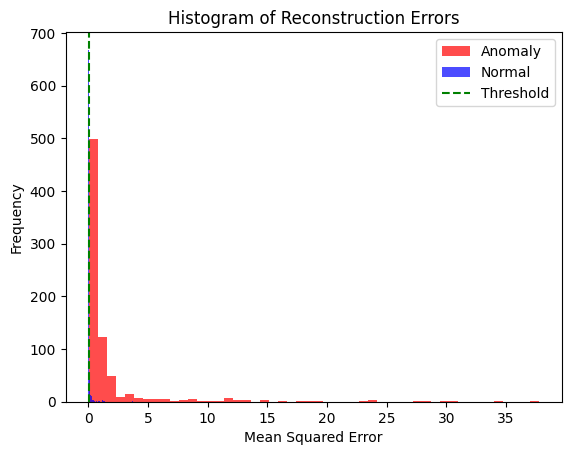

pr_auc:  0.9057217165149545
ROC AUC: 0.9604877562098277


In [68]:
# testing


# Use the trained autoencoder to reconstruct the test set
reconstructed_data = autoencoder.predict(scaled_data_test)

# Calculate Mean Squared Error for each sample
mse_per_sample = np.mean(np.square(scaled_data_test - reconstructed_data), axis=1)

# Separate anomalies and normal samples based on labels
anomalies = mse_per_sample[ty == 1]
normal_samples = mse_per_sample[ty == 0]
threshold = np.percentile(mse_per_sample,45) # Adjust this threshold as needed


# Plot histogram for anomalies
plt.hist(anomalies, bins=50, color='r', alpha=0.7, label='Anomaly')

# Plot histogram for normal samples
plt.hist(normal_samples, bins=50, color='b', alpha=0.7, label='Normal')
plt.axvline(x = threshold, color='green', linestyle='--', label='Threshold')
plt.title('Histogram of Reconstruction Errors')
plt.xlabel('Mean Squared Error')
plt.ylabel('Frequency')
plt.legend()
plt.show()

#print(mse_per_sample)



# Create binary arrays indicating whether each element is anomalous or not
anomalies = np.where(mse_per_sample > threshold, 1, 0)


fpr, tpr, thresholds = metrics.roc_curve(ty, anomalies)
pr_auc = metrics.auc(fpr, tpr)
#print(thresholds)


print("pr_auc: ",pr_auc)
print("ROC AUC:",roc_auc_score(ty, mse_per_sample))



# Dataset 6: Ozone level

In [71]:
f=np.load("/content/drive/My Drive/Colab Notebooks/Sadia/datasets/ozone-level-8hr.npz")
data = {1: "x", 2:"y" ,3:'z'}
for (i,j) in enumerate(f):
    data[i+1] = f[j]
x_train = data[1]
tx = data[2]
ty = data[3]
x_train.shape

(112, 72)

In [70]:
scaler = MinMaxScaler()
scaled_data_train = scaler.fit_transform(x_train)
scaled_data_test = scaler.transform(tx)

In [72]:
input_dim = x_train.shape[1]  # Input dimension

# Encoder
input_layer = Input(shape=(input_dim,))

autoencoder = tf.keras.models.Sequential([

    # deconstruct / encode
    tf.keras.layers.Dense(input_dim, activation='tanh', input_shape=(input_dim, )),
    #tf.keras.layers.Dense(16, activation='tanh'),
    #tf.keras.layers.Dense(256, activation='tanh'),
    #tf.keras.layers.Dense(128, activation='tanh'),
    tf.keras.layers.Dense(64, activation='tanh'),
    tf.keras.layers.Dense(32, activation='tanh'),
    tf.keras.layers.Dense(16, activation='tanh'),
    tf.keras.layers.Dense(8, activation='tanh'),

    # reconstruction / decode
    #tf.keras.layers.Dense(4, activation='tanh'),
    #tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(16, activation='tanh'),
    tf.keras.layers.Dense(32, activation='tanh'),
    tf.keras.layers.Dense(64, activation='tanh'),
    #tf.keras.layers.Dense(128, activation='tanh'),
    #tf.keras.layers.Dense(256, activation='tanh'),
    tf.keras.layers.Dense(input_dim, activation='linear')

])
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # The metric to monitor
    patience=5,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

# Compile the model
autoencoder.compile(optimizer='adam', loss='mse')

# Train the autoencoder
autoencoder.fit(scaled_data_train, scaled_data_train, epochs=30, batch_size=8, shuffle=True, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/30
12/12 [==============================] - 4s 34ms/step - loss: 0.2370 - val_loss: 0.1442
Epoch 2/30
12/12 [==============================] - 0s 9ms/step - loss: 0.0936 - val_loss: 0.0599
Epoch 3/30
12/12 [==============================] - 0s 8ms/step - loss: 0.0463 - val_loss: 0.0418
Epoch 4/30
12/12 [==============================] - 0s 9ms/step - loss: 0.0356 - val_loss: 0.0410
Epoch 5/30
12/12 [==============================] - 0s 12ms/step - loss: 0.0319 - val_loss: 0.0373
Epoch 6/30
12/12 [==============================] - 0s 10ms/step - loss: 0.0294 - val_loss: 0.0347
Epoch 7/30
12/12 [==============================] - 0s 9ms/step - loss: 0.0280 - val_loss: 0.0336
Epoch 8/30
12/12 [==============================] - 0s 9ms/step - loss: 0.0265 - val_loss: 0.0331
Epoch 9/30
12/12 [==============================] - 0s 8ms/step - loss: 0.0256 - val_loss: 0.0312
Epoch 10/30
12/12 [==============================] - 0s 5ms/step - loss: 0.0249 - val_loss: 0.0302
Epoch 11/30
12/1

3/3 [==============================] - 0s 5ms/step


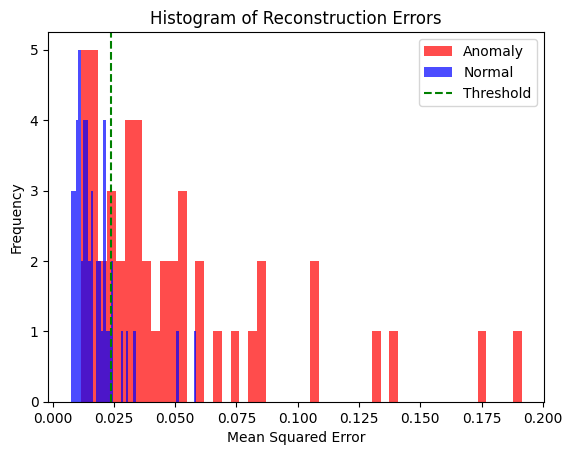

pr_auc:  0.8020833333333333
ROC AUC: 0.857204861111111


In [74]:
# testing


# Use the trained autoencoder to reconstruct the test set
reconstructed_data = autoencoder.predict(scaled_data_test)

# Calculate Mean Squared Error for each sample
mse_per_sample = np.mean(np.square(scaled_data_test - reconstructed_data), axis=1)

# Separate anomalies and normal samples based on labels
anomalies = mse_per_sample[ty == 1]
normal_samples = mse_per_sample[ty == 0]
threshold = np.percentile(mse_per_sample,55) # Adjust this threshold as needed


# Plot histogram for anomalies
plt.hist(anomalies, bins=50, color='r', alpha=0.7, label='Anomaly')

# Plot histogram for normal samples
plt.hist(normal_samples, bins=50, color='b', alpha=0.7, label='Normal')
plt.axvline(x = threshold, color='green', linestyle='--', label='Threshold')
plt.title('Histogram of Reconstruction Errors')
plt.xlabel('Mean Squared Error')
plt.ylabel('Frequency')
plt.legend()
plt.show()

#print(mse_per_sample)



# Create binary arrays indicating whether each element is anomalous or not
anomalies = np.where(mse_per_sample > threshold, 1, 0)


fpr, tpr, thresholds = metrics.roc_curve(ty, anomalies)
pr_auc = metrics.auc(fpr, tpr)
#print(thresholds)


print("pr_auc: ",pr_auc)
print("ROC AUC:",roc_auc_score(ty, mse_per_sample))



# Dataset 7: Vowels

In [77]:
f=np.load("/content/drive/My Drive/Colab Notebooks/Sadia/datasets/vowels.npz")
data = {1: "x", 2:"y" ,3:'z'}
for (i,j) in enumerate(f):
    data[i+1] = f[j]
x_train = data[1]
tx = data[2]
ty = data[3]


(1356, 12)

In [76]:
scaler = StandardScaler()
scaled_data_train = scaler.fit_transform(x_train)
scaled_data_test = scaler.transform(tx)

In [80]:
input_dim = x_train.shape[1]  # Input dimension

# Encoder
input_layer = Input(shape=(input_dim,))

autoencoder = tf.keras.models.Sequential([

    # deconstruct / encode
    tf.keras.layers.Dense(input_dim, activation='tanh', input_shape=(input_dim, )),
    #tf.keras.layers.Dense(16, activation='tanh'),
    tf.keras.layers.Dense(256, activation='tanh'),
    tf.keras.layers.Dense(128, activation='tanh'),
    tf.keras.layers.Dense(64, activation='tanh'),
    tf.keras.layers.Dense(32, activation='tanh'),
    tf.keras.layers.Dense(16, activation='tanh'),
    tf.keras.layers.Dense(8, activation='tanh'),

    # reconstruction / decode
    #tf.keras.layers.Dense(4, activation='tanh'),
    #tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(16, activation='tanh'),
    tf.keras.layers.Dense(32, activation='tanh'),
    tf.keras.layers.Dense(64, activation='tanh'),
    tf.keras.layers.Dense(128, activation='tanh'),
    tf.keras.layers.Dense(256, activation='tanh'),
    tf.keras.layers.Dense(input_dim, activation='linear')

])

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # The metric to monitor
    patience=5,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)
# Compile the model
autoencoder.compile(optimizer='adam', loss='mse')

# Train the autoencoder
autoencoder.fit(scaled_data_train, scaled_data_train, epochs=30, batch_size=8, shuffle=True, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/30
136/136 [==============================] - 6s 12ms/step - loss: 0.3307 - val_loss: 0.1888
Epoch 2/30
136/136 [==============================] - 1s 4ms/step - loss: 0.1820 - val_loss: 0.1572
Epoch 3/30
136/136 [==============================] - 0s 4ms/step - loss: 0.1505 - val_loss: 0.1257
Epoch 4/30
136/136 [==============================] - 1s 6ms/step - loss: 0.1211 - val_loss: 0.0985
Epoch 5/30
136/136 [==============================] - 1s 8ms/step - loss: 0.0974 - val_loss: 0.0929
Epoch 6/30
136/136 [==============================] - 1s 5ms/step - loss: 0.0885 - val_loss: 0.0897
Epoch 7/30
136/136 [==============================] - 1s 7ms/step - loss: 0.0829 - val_loss: 0.0785
Epoch 8/30
136/136 [==============================] - 2s 11ms/step - loss: 0.0775 - val_loss: 0.0770
Epoch 9/30
136/136 [==============================] - 2s 14ms/step - loss: 0.0743 - val_loss: 0.0739
Epoch 10/30
136/136 [==============================] - 3s 23ms/step - loss: 0.0721 - val_loss: 0.

4/4 [==============================] - 0s 4ms/step


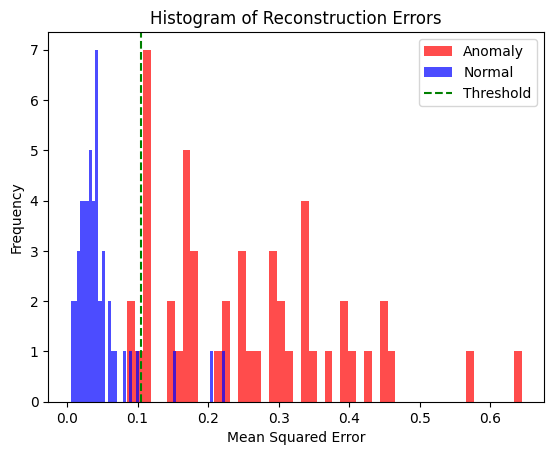

pr_auc:  0.94
ROC AUC: 0.9764


In [81]:
# testing


# Use the trained autoencoder to reconstruct the test set
reconstructed_data = autoencoder.predict(scaled_data_test)

# Calculate Mean Squared Error for each sample
mse_per_sample = np.mean(np.square(scaled_data_test - reconstructed_data), axis=1)

# Separate anomalies and normal samples based on labels
anomalies = mse_per_sample[ty == 1]
normal_samples = mse_per_sample[ty == 0]
threshold = np.percentile(mse_per_sample,50) # Adjust this threshold as needed


# Plot histogram for anomalies
plt.hist(anomalies, bins=50, color='r', alpha=0.7, label='Anomaly')

# Plot histogram for normal samples
plt.hist(normal_samples, bins=50, color='b', alpha=0.7, label='Normal')
plt.axvline(x = threshold, color='green', linestyle='--', label='Threshold')
plt.title('Histogram of Reconstruction Errors')
plt.xlabel('Mean Squared Error')
plt.ylabel('Frequency')
plt.legend()
plt.show()

#print(mse_per_sample)



# Create binary arrays indicating whether each element is anomalous or not
anomalies = np.where(mse_per_sample > threshold, 1, 0)


fpr, tpr, thresholds = metrics.roc_curve(ty, anomalies)
pr_auc = metrics.auc(fpr, tpr)
#print(thresholds)


print("pr_auc: ",pr_auc)
print("ROC AUC:",roc_auc_score(ty, mse_per_sample))



# Dataset 8: Waveform

In [96]:
f=np.load("/content/drive/My Drive/Colab Notebooks/Sadia/datasets/waveform-5000.npz")
data = {1: "x", 2:"y" ,3:'z'}
for (i,j) in enumerate(f):
    data[i+1] = f[j]
x_train = data[1]
tx = data[2]
ty = data[3]
tx.shape

(1014, 40)

In [91]:
scaler = StandardScaler()
scaled_data_train = scaler.fit_transform(x_train)
scaled_data_test = scaler.transform(tx)

In [97]:
input_dim = x_train.shape[1]  # Input dimension

# Encoder
input_layer = Input(shape=(input_dim,))

autoencoder = tf.keras.models.Sequential([

    # deconstruct / encode
    tf.keras.layers.Dense(input_dim, activation='tanh', input_shape=(input_dim, )),
    #tf.keras.layers.Dense(16, activation='tanh'),
    #tf.keras.layers.Dense(256, activation='tanh'),
    #tf.keras.layers.Dense(128, activation='tanh'),
    #tf.keras.layers.Dense(64, activation='tanh'),
    tf.keras.layers.Dense(32, activation='tanh'),
    tf.keras.layers.Dense(16, activation='tanh'),
    tf.keras.layers.Dense(8, activation='tanh'),
    tf.keras.layers.Dense(4, activation='tanh'),

    # reconstruction / decode
    #tf.keras.layers.Dense(4, activation='tanh'),
    tf.keras.layers.Dense(8, activation='tanh'),
    tf.keras.layers.Dense(16, activation='tanh'),
    tf.keras.layers.Dense(32, activation='tanh'),
    #tf.keras.layers.Dense(64, activation='tanh'),
    #tf.keras.layers.Dense(128, activation='tanh'),
    #tf.keras.layers.Dense(256, activation='tanh'),
    tf.keras.layers.Dense(input_dim, activation='linear')

])

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # The metric to monitor
    patience=5,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)
# Compile the model
autoencoder.compile(optimizer='adam', loss='mse')

# Train the autoencoder
autoencoder.fit(scaled_data_train, scaled_data_train, epochs=30, batch_size=8, shuffle=True, validation_split=0.2, callbacks=[early_stopping] )

Epoch 1/30
119/119 [==============================] - 4s 8ms/step - loss: 0.8732 - val_loss: 0.7556
Epoch 2/30
119/119 [==============================] - 0s 3ms/step - loss: 0.7606 - val_loss: 0.7293
Epoch 3/30
119/119 [==============================] - 0s 3ms/step - loss: 0.7440 - val_loss: 0.7170
Epoch 4/30
119/119 [==============================] - 0s 3ms/step - loss: 0.7316 - val_loss: 0.7093
Epoch 5/30
119/119 [==============================] - 0s 3ms/step - loss: 0.7240 - val_loss: 0.7054
Epoch 6/30
119/119 [==============================] - 0s 3ms/step - loss: 0.7191 - val_loss: 0.7020
Epoch 7/30
119/119 [==============================] - 0s 3ms/step - loss: 0.7153 - val_loss: 0.7002
Epoch 8/30
119/119 [==============================] - 0s 3ms/step - loss: 0.7120 - val_loss: 0.6996
Epoch 9/30
119/119 [==============================] - 0s 3ms/step - loss: 0.7101 - val_loss: 0.6989
Epoch 10/30
119/119 [==============================] - 0s 3ms/step - loss: 0.7078 - val_loss: 0.6975

32/32 [==============================] - 0s 2ms/step


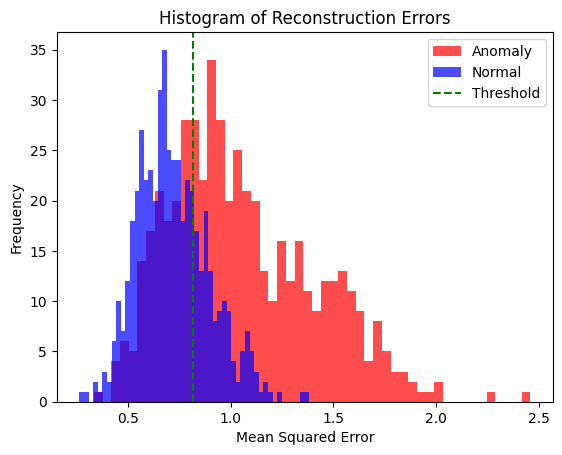

pr_auc:  0.7199211045364892
ROC AUC: 0.7973654828456831


In [98]:
# testing


# Use the trained autoencoder to reconstruct the test set
reconstructed_data = autoencoder.predict(scaled_data_test)

# Calculate Mean Squared Error for each sample
mse_per_sample = np.mean(np.square(scaled_data_test - reconstructed_data), axis=1)

# Separate anomalies and normal samples based on labels
anomalies = mse_per_sample[ty == 1]
normal_samples = mse_per_sample[ty == 0]
threshold = np.percentile(mse_per_sample,50) # Adjust this threshold as needed


# Plot histogram for anomalies
plt.hist(anomalies, bins=50, color='r', alpha=0.7, label='Anomaly')

# Plot histogram for normal samples
plt.hist(normal_samples, bins=50, color='b', alpha=0.7, label='Normal')
plt.axvline(x = threshold, color='green', linestyle='--', label='Threshold')
plt.title('Histogram of Reconstruction Errors')
plt.xlabel('Mean Squared Error')
plt.ylabel('Frequency')
plt.legend()
plt.show()

#print(mse_per_sample)



# Create binary arrays indicating whether each element is anomalous or not
anomalies = np.where(mse_per_sample > threshold, 1, 0)


fpr, tpr, thresholds = metrics.roc_curve(ty, anomalies)
pr_auc = metrics.auc(fpr, tpr)
#print(thresholds)


print("pr_auc: ",pr_auc)
print("ROC AUC:",roc_auc_score(ty, mse_per_sample))

